# Install neccessary packages

In [1]:
!pip install autogluon matplotlib

  Obtaining dependency information for autogluon.core[all]==0.8.2 from https://files.pythonhosted.org/packages/e0/56/545adb1d388e78591cd7e36de0c8b889c1944de362bdaeec0f31d01890df/autogluon.core-0.8.2-py3-none-any.whl.metadata
  Using cached autogluon.core-0.8.2-py3-none-any.whl.metadata (12 kB)
  Obtaining dependency information for autogluon.features==0.8.2 from https://files.pythonhosted.org/packages/bb/ea/7892719f78a30aee1bf42c4a0540fbae98bfbdf56b85fab79ffc437eb687/autogluon.features-0.8.2-py3-none-any.whl.metadata
  Using cached autogluon.features-0.8.2-py3-none-any.whl.metadata (11 kB)
  Obtaining dependency information for autogluon.tabular[all]==0.8.2 from https://files.pythonhosted.org/packages/f3/dc/0bd8cadb9a5e2f3e5b12caaa6745357d912ffc7b8b75fb4e426a38331028/autogluon.tabular-0.8.2-py3-none-any.whl.metadata
  Using cached autogluon.tabular-0.8.2-py3-none-any.whl.metadata (13 kB)
  Obtaining dependency information for autogluon.multimodal==0.8.2 from https://files.pythonhosted.

# Config

In [31]:
# config

label = 'y'
metric = 'mean_absolute_error'
time_limit = None
presets = "experimental_zeroshot_hpo_hybrid"#'best_quality'

use_is_estimated_attr = True

drop_night_outliers = True

# to_drop = ["snow_drift:idx", "snow_density:kgm3", "wind_speed_w_1000hPa:ms", "dew_or_rime:idx", "prob_rime:p", "fresh_snow_12h:cm", "fresh_snow_24h:cm", "wind_speed_u_10m:ms", "wind_speed_v_10m:ms", "snow_melt_10min:mm", "rain_water:kgm2", "dew_point_2m:K", "precip_5min:mm", "absolute_humidity_2m:gm3", "air_density_2m:kgm3"]#, "msl_pressure:hPa", "pressure_50m:hPa",  "pressure_100m:hPa"]
to_drop = ["wind_speed_w_1000hPa:ms", "wind_speed_u_10m:ms", "wind_speed_v_10m:ms"]

excluded_model_types = ['CAT', 'XGB', 'RF']

num_stack_levels = 0
num_bag_folds = 8#8# 8
num_bag_sets = 3##20

use_tune_data = True
use_test_data = True
use_bag_holdout = True 

clip_predictions = True

# Loading and preprocessing

In [32]:
import pandas as pd
import numpy as np



import warnings
warnings.filterwarnings("ignore")


def feature_engineering(X):
    # shift columns with them by 1 hour, so that for index 16:00, we have the values from 17:00
    columns = ['clear_sky_energy_1h:J', 'diffuse_rad_1h:J', 'direct_rad_1h:J',
               'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
               'fresh_snow_3h:cm', 'fresh_snow_6h:cm']

    # Filter rows where index.minute == 0
    X_shifted = X[X.index.minute == 0][columns].copy()

    # Create a set for constant-time lookup
    index_set = set(X.index)

    # Vectorized time shifting
    one_hour = pd.Timedelta('1 hour')
    shifted_indices = X_shifted.index + one_hour
    X_shifted.loc[shifted_indices.isin(index_set)] = X.loc[shifted_indices[shifted_indices.isin(index_set)]][columns]

    # set last row to same as second last row
    X_shifted.iloc[-1] = X_shifted.iloc[-2]


    # Rename columns
    X_old_unshifted = X_shifted.copy()
    X_old_unshifted.columns = [f"{col}_not_shifted" for col in X_old_unshifted.columns]
    
    date_calc = None
    # If 'date_calc' is present, handle it
    if 'date_calc' in X.columns:
        date_calc = X[X.index.minute == 0]['date_calc']


  

    # resample to hourly
    X = X.resample('H').mean()

    # overwrite columns with shifted columns
    X[columns] = X_shifted[columns]

    if date_calc is not None:
        X['date_calc'] = date_calc

    return X




def fix_X(X, name):
    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    
    X = feature_engineering(X)

    return X



def handle_features(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_X(X_train_observed, "X_train_observed")
    X_train_estimated = fix_X(X_train_estimated, "X_train_estimated")
    X_test = fix_X(X_test, "X_test")


    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = handle_features(X_train_observed, X_train_estimated, X_test, y_train)

    if use_is_estimated_attr:
        X_train_observed["is_estimated"] = 0
        X_train_estimated["is_estimated"] = 1
        X_test["is_estimated"] = 1

    # drop date_calc
    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)


    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    X_train = pd.concat([X_train_observed, X_train_estimated])
    
    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    X_train = pd.merge(X_train, y_train, how="inner", left_index=True, right_index=True)


    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test

# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
# Loop through locations
for loc in locations:
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)



Processing location A...
Processing location B...
Processing location C...


## Feature enginering

### Remove anomalies

In [33]:
import pandas as pd

def replace_streaks_with_nan(df, max_streak_length, column="y"):
    for location in df["location"].unique():
        x = df[df["location"] == location][column].copy()

        last_val = None
        streak_length = 1
        streak_indices = []
        allowed = [0]
        found_streaks = {}

        for idx in x.index:
            value = x[idx]

            if value == last_val and value not in allowed:
                streak_length += 1
                streak_indices.append(idx)
            else:
                streak_length = 1
                last_val = value
                streak_indices.clear()

            if streak_length > max_streak_length:
                found_streaks[value] = streak_length

                for streak_idx in streak_indices:
                    x[idx] = np.nan
                streak_indices.clear()  # clear after setting to NaN to avoid setting multiple times
        df.loc[df["location"] == location, column] = x

        print(f"Found streaks for location {location}: {found_streaks}")

    return df


X_train = replace_streaks_with_nan(X_train.copy(), 3, "y")

Found streaks for location A: {}
Found streaks for location B: {3.45: 28, 6.9: 7, 12.9375: 5, 13.8: 8, 276.0: 78, 18.975: 58, 0.8625: 4, 118.1625: 33, 34.5: 11, 183.7125: 1058, 87.1125: 7, 79.35: 34, 7.7625: 12, 27.6: 448, 273.41249999999997: 72, 264.78749999999997: 55, 169.05: 33, 375.1875: 56, 314.8125: 66, 76.7625: 10, 135.4125: 216, 81.9375: 202, 2.5875: 12, 81.075: 210}
Found streaks for location C: {9.8: 4, 29.400000000000002: 4, 19.6: 4}


In [34]:
# print num rows
temprows = len(X_train)
X_train.dropna(subset=['y', 'direct_rad_1h:J', 'diffuse_rad_1h:J'], inplace=True)
print("Dropped rows: ", temprows - len(X_train))


Dropped rows:  9293


In [35]:
thresh = 0.1
mask = (X_train["direct_rad_1h:J"] <= thresh) & (X_train["diffuse_rad_1h:J"] <= thresh) & (X_train["y"] >= 0.1)

if drop_night_outliers:
    X_train.loc[mask, "y"] = np.nan

In [36]:
temprows = len(X_train)
X_train.dropna(subset=['y', 'direct_rad_1h:J', 'diffuse_rad_1h:J'], inplace=True)
print("Dropped rows: ", temprows - len(X_train))

Dropped rows:  1876


In [37]:
X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)

In [38]:
def split_and_shuffle_data(input_data, num_bins, frac1):
    # Validate the input fraction
    if frac1 < 0 or frac1 > 1:
        raise ValueError("frac1 must be between 0 and 1.")
    
    if frac1==1:
        return input_data, pd.DataFrame()

    # Calculate the fraction for the second output set
    frac2 = 1 - frac1
    
    # Calculate bin size
    bin_size = len(input_data) // num_bins

    # Initialize empty DataFrames for output
    output_data1 = pd.DataFrame()
    output_data2 = pd.DataFrame()

    for i in range(num_bins):
        # Shuffle the data in the current bin
        np.random.seed(i)
        current_bin = input_data.iloc[i * bin_size: (i + 1) * bin_size].sample(frac=1)
        
        # Calculate the sizes for each output set
        size1 = int(len(current_bin) * frac1)
        
        # Split and append to output DataFrames
        output_data1 = pd.concat([output_data1, current_bin.iloc[:size1]])
        output_data2 = pd.concat([output_data2, current_bin.iloc[size1:]])

    # Shuffle and split the remaining data
    remaining_data = input_data.iloc[num_bins * bin_size:].sample(frac=1)

    remaining_size1 = int(len(remaining_data) * frac1)
    
    output_data1 = pd.concat([output_data1, remaining_data.iloc[:remaining_size1]])
    output_data2 = pd.concat([output_data2, remaining_data.iloc[remaining_size1:]])

    return output_data1, output_data2


In [39]:
from autogluon.tabular import TabularDataset, TabularPredictor
data = TabularDataset('X_train_raw.csv')
data['ds'] = pd.to_datetime(data['ds'])
data = data.sort_values(by='ds')

split_time = pd.to_datetime("2022-10-28 22:00:00")
train_set = TabularDataset(data[data["ds"] < split_time])
estimated_set = TabularDataset(data[data["ds"] >= split_time]) # only estimated

test_set = pd.DataFrame()
tune_set = pd.DataFrame()
new_train_set = pd.DataFrame()

for location in locations:
    loc_data = data[data["location"] == location]
    num_train_rows = len(loc_data)
    
    tune_rows = 1500.0 # 2500.0
    if use_test_data:
        tune_rows = 1880.0#max(3000.0, len(estimated_set[estimated_set["location"] == location]))

    holdout_frac = max(0.01, min(0.1, tune_rows / num_train_rows)) * num_train_rows / len(estimated_set[estimated_set["location"] == location])

    # shuffle and split data
    loc_tune_set, loc_new_train_set = split_and_shuffle_data(estimated_set[estimated_set['location'] == location], 40, holdout_frac)

    new_train_set = pd.concat([new_train_set, loc_new_train_set])

    if use_test_data:
        loc_test_set, loc_tune_set = split_and_shuffle_data(loc_tune_set, 40, 0.2)
        test_set = pd.concat([test_set, loc_test_set])

    tune_set = pd.concat([tune_set, loc_tune_set])

# add rest to train_set
train_set = pd.concat([train_set, new_train_set])
tuning_data = tune_set
if use_test_data:
    test_data = test_set

train_data = train_set

train_data = TabularDataset(train_data)
tuning_data = TabularDataset(tuning_data)

if use_test_data:
    test_data = TabularDataset(test_data)

Loaded data from: X_train_raw.csv | Columns = 46 / 46 | Rows = 87917 -> 87917


# Modeling

In [40]:
import os


# if submissions folder does not exist, create it
if not os.path.exists('submissions'):
    os.makedirs('submissions')

# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)
print("Now creating submission number:", last_submission_number + 1)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}'

print("New filename:", new_filename)

Last submission number: 134
Now creating submission number: 135
New filename: submission_135


In [41]:
predictors = [None, None, None]

In [42]:
def fit_predictor_for_location(loc):
    # All of these hyperparameters have been found by experimenting with some standard parameters in AutoGluon, and then only using the best ones for each location to make the train time shorter
    r118 = {'extra_trees': True, 'feature_fraction': 0.7832570544199176, 'learning_rate': 0.021720607471727896, 'min_data_in_leaf': 3, 'num_leaves': 21, 'ag_args': {'name_suffix': '_r118', 'priority': 17}}
    r51 = {'bs': 1024, 'emb_drop': 0.6046989241462619, 'epochs': 48, 'layers': [200, 100, 50], 'lr': 0.00775309042164966, 'ps': 0.09244767444160731, 'ag_args': {'name_suffix': '_r51', 'priority': 12}}
    r145 = {'bs': 128, 'emb_drop': 0.44339037504795686, 'epochs': 31, 'layers': [400, 200, 100], 'lr': 0.008615195908919904, 'ps': 0.19220253419114286, 'ag_args': {'name_suffix': '_r145', 'priority': 9}}
    lgbmXT = {'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}
    if loc == "A":
        hyperparameters = {
            'NN_TORCH': {},
            'GBM': [lgbmXT, r118, 'GBMLarge'],#, r_118],
            'FASTAI': [r51],
        }
    elif loc == "B":
        hyperparameters = {
            'NN_TORCH': {},
            'GBM': [r118],
            'FASTAI': [{}, r145],
        }

    elif loc == "C":
        hyperparameters = {
            'NN_TORCH': {},
	        'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}}],
            'GBM': [r118],
            'FASTAI': [r51],
        }


    predictor = TabularPredictor(
        label=label, 
        eval_metric=metric, 
        path=f"AutogluonModels/{new_filename}_{loc}", 
    ).fit(
        train_data=train_data[train_data["location"] == loc].drop(columns=["ds"]),
        time_limit=time_limit, 
        presets=presets, 
        num_stack_levels=num_stack_levels,
        num_bag_folds=num_bag_folds,
        num_bag_sets=num_bag_sets,
        tuning_data=tuning_data[tuning_data["location"] == loc].reset_index(drop=True).drop(columns=["ds"]),
        hyperparameters = hyperparameters,
        use_bag_holdout=use_bag_holdout,
        #excluded_model_types=excluded_model_types
    )

    # evaluate on test data
    if use_test_data:
        t = test_data[test_data["location"] == loc]
        perf = predictor.evaluate(t)
        print("Evaluation on test data:")
        print(perf[predictor.eval_metric.name])

    return predictor

loc = "A"
predictors[0] = fit_predictor_for_location(loc)



Presets specified: ['experimental_zeroshot_hpo_hybrid']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=3
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_135_A/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   99.14 GB / 494.38 GB (20.1%)
Train Data Rows:    30934
Train Data Columns: 44
Tuning Data Rows:    1485
Tuning Data Columns: 44
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5733.42, 0.0, 673.41535, 1195.24)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You 

[1000]	valid_set's l1: 188.903
[2000]	valid_set's l1: 183.38
[3000]	valid_set's l1: 180.745
[4000]	valid_set's l1: 178.855
[5000]	valid_set's l1: 177.036
[6000]	valid_set's l1: 176.178
[7000]	valid_set's l1: 175.372
[8000]	valid_set's l1: 174.791
[9000]	valid_set's l1: 174.317
[10000]	valid_set's l1: 173.968
[1000]	valid_set's l1: 195.036
[2000]	valid_set's l1: 190.396
[3000]	valid_set's l1: 187.398
[4000]	valid_set's l1: 185.562
[5000]	valid_set's l1: 184.402
[6000]	valid_set's l1: 183.498
[7000]	valid_set's l1: 182.975
[8000]	valid_set's l1: 182.6
[9000]	valid_set's l1: 182.308
[10000]	valid_set's l1: 182.089
[1000]	valid_set's l1: 174.756
[2000]	valid_set's l1: 170.021
[3000]	valid_set's l1: 167.451
[4000]	valid_set's l1: 166.491
[5000]	valid_set's l1: 165.668
[6000]	valid_set's l1: 164.958
[7000]	valid_set's l1: 164.495
[8000]	valid_set's l1: 164.319
[9000]	valid_set's l1: 164.064
[10000]	valid_set's l1: 163.91
[1000]	valid_set's l1: 185.905
[2000]	valid_set's l1: 180.669
[3000]	va

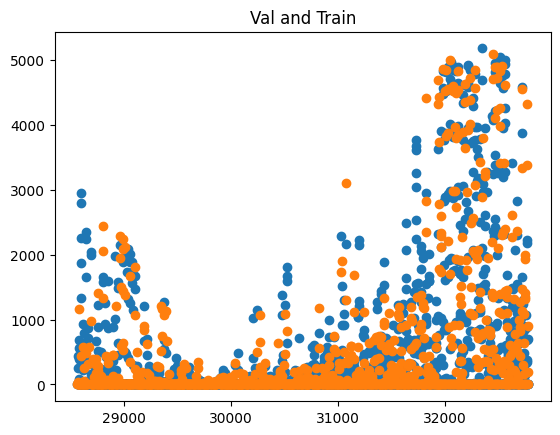

                 model  score_test   score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           LightGBMXT -105.076269  -87.205583        0.115398       0.244988  124.749232                 0.115398                0.244988         124.749232            1       True          1
1  WeightedEnsemble_L2 -107.127612  -81.125258        0.242244       0.409461  221.054471                 0.001384                0.000182           0.041240            2       True          5
2        LightGBM_r118 -108.328987  -84.836682        0.096456       0.145051   56.539522                 0.096456                0.145051          56.539522            1       True          3
3  NeuralNetFastAI_r51 -118.222040 -102.470368        0.014375       0.007416   14.233863                 0.014375                0.007416          14.233863            1       True          4
4       NeuralNetTorch -121.957260 

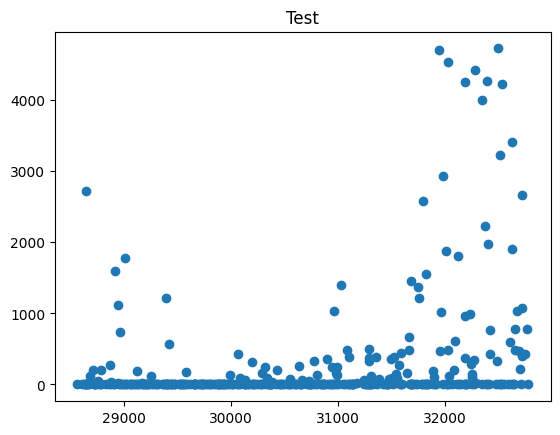

In [ ]:
import matplotlib.pyplot as plt
leaderboards = [None, None, None]
def leaderboard_for_location(i, loc):
    plt.scatter(train_data[(train_data["location"] == loc) & (train_data["is_estimated"]==True)]["y"].index, train_data[(train_data["location"] == loc) & (train_data["is_estimated"]==True)]["y"])
    plt.scatter(tuning_data[tuning_data["location"] == loc]["y"].index, tuning_data[tuning_data["location"] == loc]["y"])
    plt.title("Val and Train")
    plt.show()

    if use_test_data:
        lb = predictors[i].leaderboard(test_data[test_data["location"] == loc])
        lb["location"] = loc
        plt.scatter(test_data[test_data["location"] == loc]["y"].index, test_data[test_data["location"] == loc]["y"])
        plt.title("Test")
        
        return lb
    
    return pd.DataFrame()

leaderboards[0] = leaderboard_for_location(0, loc)

In [ ]:
loc = "B"
predictors[1] = fit_predictor_for_location(loc)
leaderboards[1] = leaderboard_for_location(1, loc)

Presets specified: ['experimental_zeroshot_hpo_hybrid']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=0
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_135_B/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   100.55 GB / 494.38 GB (20.3%)
Train Data Rows:    27377
Train Data Columns: 47
Tuning Data Rows:    1485
Tuning Data Columns: 47
Label Column: y
Preprocessing data ...


AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (1152.3, -0.0, 98.11625, 206.48535)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    3122.04 MB
	Train Data (Original)  Memory Usage: 12.3 MB (0.4% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting 

[1000]	valid_set's l1: 14.2773
[2000]	valid_set's l1: 14.0181
[3000]	valid_set's l1: 13.957
[4000]	valid_set's l1: 13.8745
[5000]	valid_set's l1: 13.8621
[6000]	valid_set's l1: 13.8212
[7000]	valid_set's l1: 13.8141
[8000]	valid_set's l1: 13.7824
[9000]	valid_set's l1: 13.7291


KeyboardInterrupt: 

Presets specified: ['experimental_zeroshot_hpo_hybrid']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=0
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/submission_134_C/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   100.63 GB / 494.38 GB (20.4%)
Train Data Rows:    24073
Train Data Columns: 47
Tuning Data Rows:    1481
Tuning Data Columns: 47
Label Column: y
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (999.6, -0.0, 80.87539, 169.67845)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init

[1000]	valid_set's l1: 12.5619
[2000]	valid_set's l1: 11.7336
[3000]	valid_set's l1: 11.5889


	-11.5594	 = Validation score   (-mean_absolute_error)
	25.45s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-12.2202	 = Validation score   (-mean_absolute_error)
	43.72s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: LightGBM_r118 ...


[1000]	valid_set's l1: 13.5054
[2000]	valid_set's l1: 12.4438
[3000]	valid_set's l1: 11.89
[4000]	valid_set's l1: 11.6741
[5000]	valid_set's l1: 11.4779
[6000]	valid_set's l1: 11.3679
[7000]	valid_set's l1: 11.316
[8000]	valid_set's l1: 11.2841
[9000]	valid_set's l1: 11.2212
[10000]	valid_set's l1: 11.195


	-11.1909	 = Validation score   (-mean_absolute_error)
	82.2s	 = Training   runtime
	0.28s	 = Validation runtime
Fitting model: NeuralNetFastAI_r51 ...
	-13.4989	 = Validation score   (-mean_absolute_error)
	68.52s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-10.7391	 = Validation score   (-mean_absolute_error)
	0.08s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 226.87s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/submission_134_C/")
Evaluation: mean_absolute_error on test data: -11.096687568183471
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "mean_absolute_error": -11.096687568183471,
    "root_mean_squared_error": -26.67684023698341,
    "mean_squared_error": -711.6538050295371,
    "r2": 0.9278640745308446,
    

Evaluation on test data:
-11.096687568183471


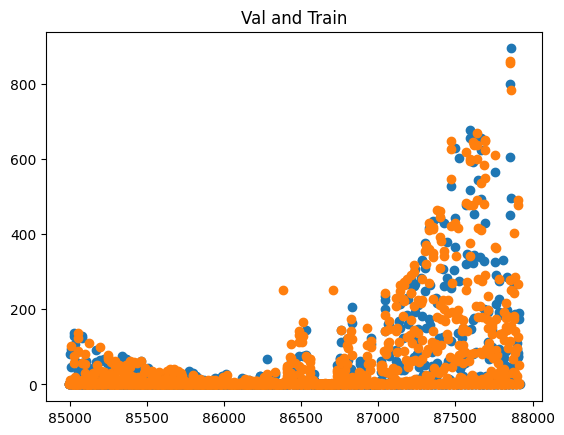

                 model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2  -11.096688 -10.739141       12.911151       5.084761  220.005957                 0.002081                0.000204           0.083005            2       True          6
1        LightGBM_r118  -11.531620 -11.190891        0.322478       0.276384   82.199734                 0.322478                0.276384          82.199734            1       True          4
2           LightGBMXT  -12.545529 -11.559353        0.133682       0.036625   25.454035                 0.133682                0.036625          25.454035            1       True          2
3       NeuralNetTorch  -13.048661 -12.220150        0.092223       0.014784   43.720339                 0.092223                0.014784          43.720339            1       True          3
4  NeuralNetFastAI_r51  -14.205124 -13.4

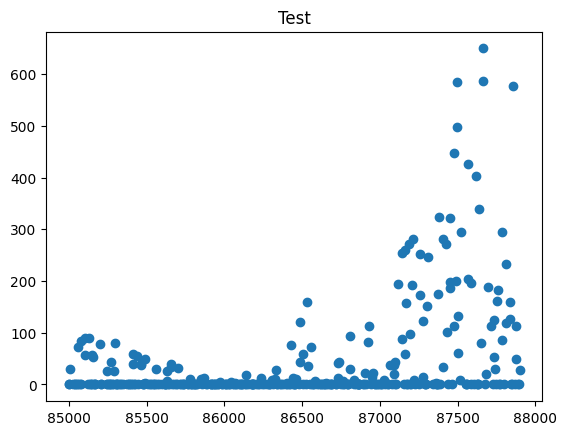

In [ ]:
loc = "C"
predictors[2] = fit_predictor_for_location(loc)
leaderboards[2] = leaderboard_for_location(2, loc)

In [ ]:
# save leaderboards to csv
pd.concat(leaderboards).to_csv(f"leaderboards/{new_filename}.csv")


for i in range(len(predictors)):
    print(f"Predictor {i}:")
    print(predictors[i].info()["model_info"]["WeightedEnsemble_L2"]["children_info"]["S1F1"]["model_weights"])

Predictor 0:
{'LightGBMXT': 0.5147058823529411, 'NeuralNetTorch': 0.4852941176470588}
Predictor 1:
{'ExtraTreesMSE': 0.015151515151515152, 'NeuralNetFastAI': 0.045454545454545456, 'NeuralNetTorch': 0.21212121212121213, 'LightGBM_r118': 0.4393939393939394, 'NeuralNetFastAI_r51': 0.09090909090909091, 'NeuralNetFastAI_r145': 0.19696969696969696}
Predictor 2:
{'KNeighborsUnif': 0.06756756756756757, 'LightGBMXT': 0.13513513513513514, 'NeuralNetTorch': 0.3108108108108108, 'LightGBM_r118': 0.4594594594594595, 'NeuralNetFastAI_r51': 0.02702702702702703}


# Submit

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

future_test_data = TabularDataset('X_test_raw.csv')
future_test_data["ds"] = pd.to_datetime(future_test_data["ds"])

Loaded data from: X_test_raw.csv | Columns = 48 / 48 | Rows = 4608 -> 4608


In [ ]:
test_ids = TabularDataset('test.csv')
test_ids["time"] = pd.to_datetime(test_ids["time"])
# merge test_data with test_ids
future_test_data_merged = pd.merge(future_test_data, test_ids, how="inner", right_on=["time", "location"], left_on=["ds", "location"])

Loaded data from: test.csv | Columns = 4 / 4 | Rows = 2160 -> 2160


In [ ]:
# predict, grouped by location
predictions = []
location_map = {
    "A": 0,
    "B": 1,
    "C": 2
}
for loc, group in future_test_data.groupby('location'):
    i = location_map[loc]
    subset = future_test_data_merged[future_test_data_merged["location"] == loc].reset_index(drop=True)
    pred = predictors[i].predict(subset)
    subset["prediction"] = pred
    predictions.append(subset)

    # get past predictions
    tuning_data.loc[tuning_data["location"] == loc, "prediction"] =  predictors[i].predict(tuning_data[tuning_data["location"] == loc])
    if use_test_data:
        # get predictions for local test_data
        test_data.loc[test_data["location"] == loc, "prediction"] =  predictors[i].predict(test_data[test_data["location"] == loc])  

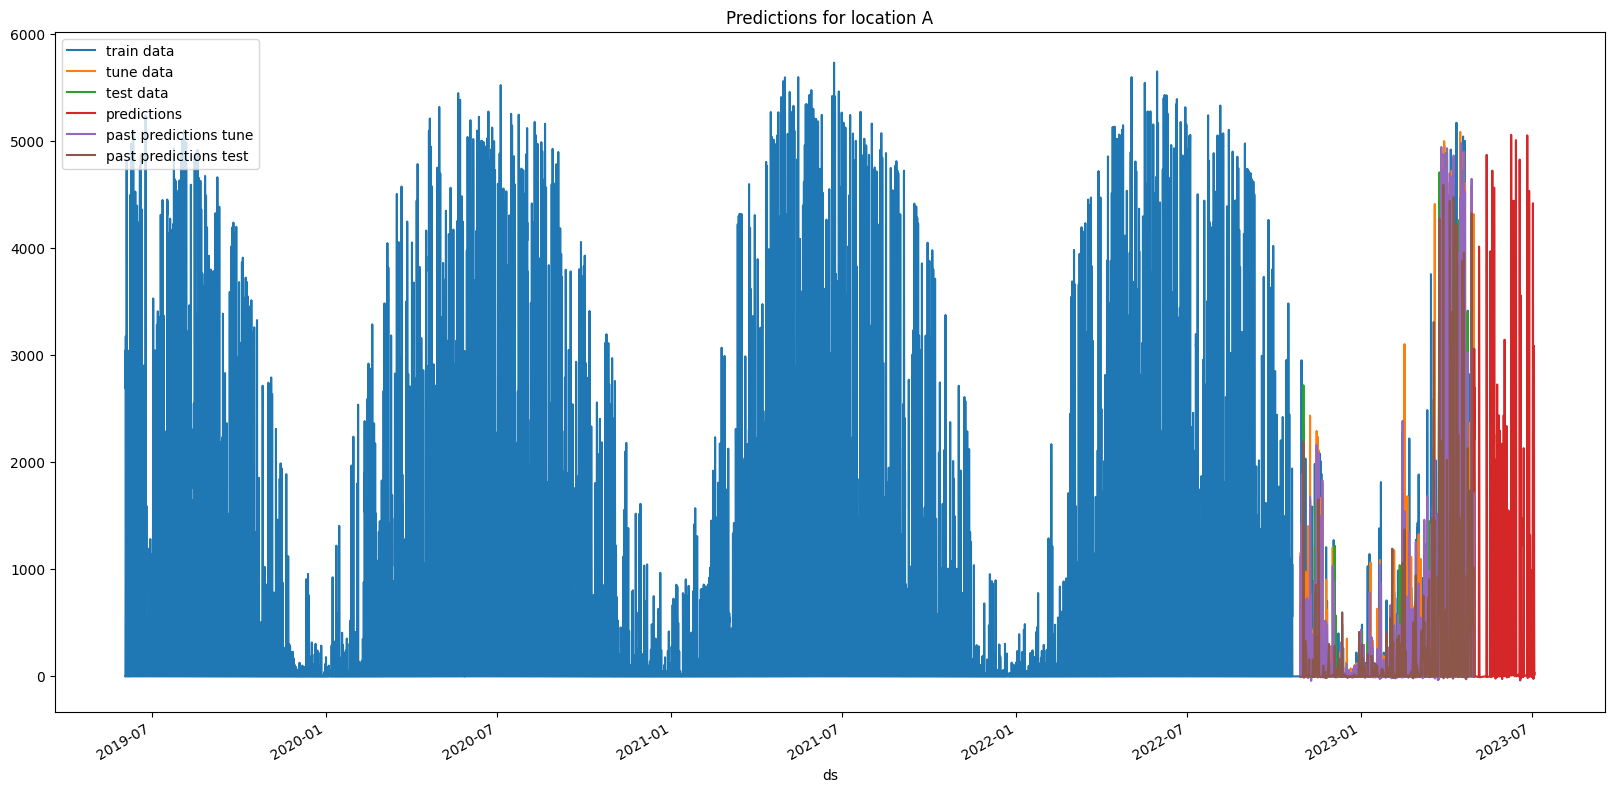

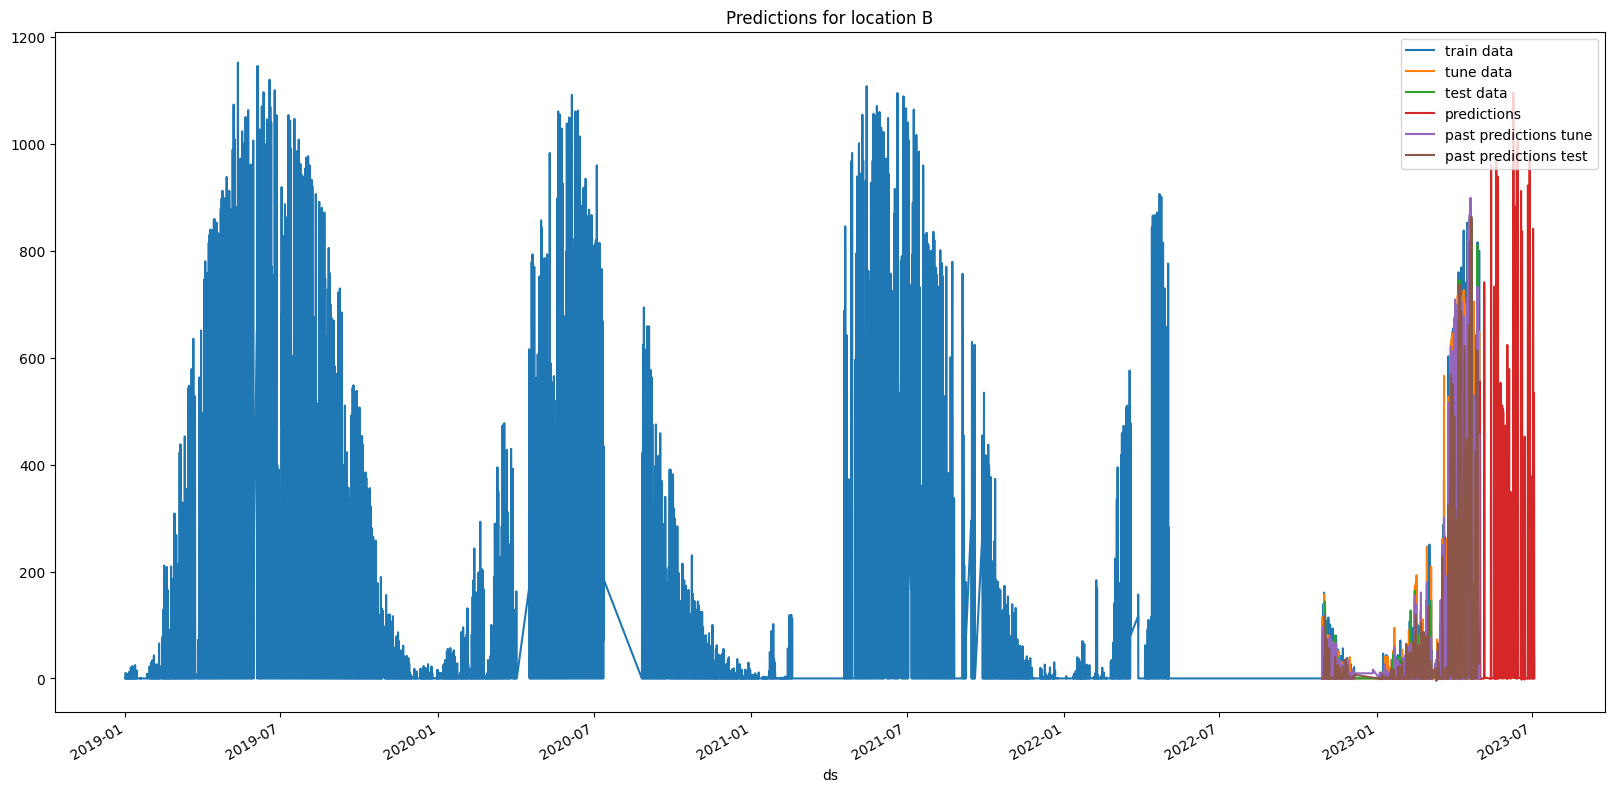

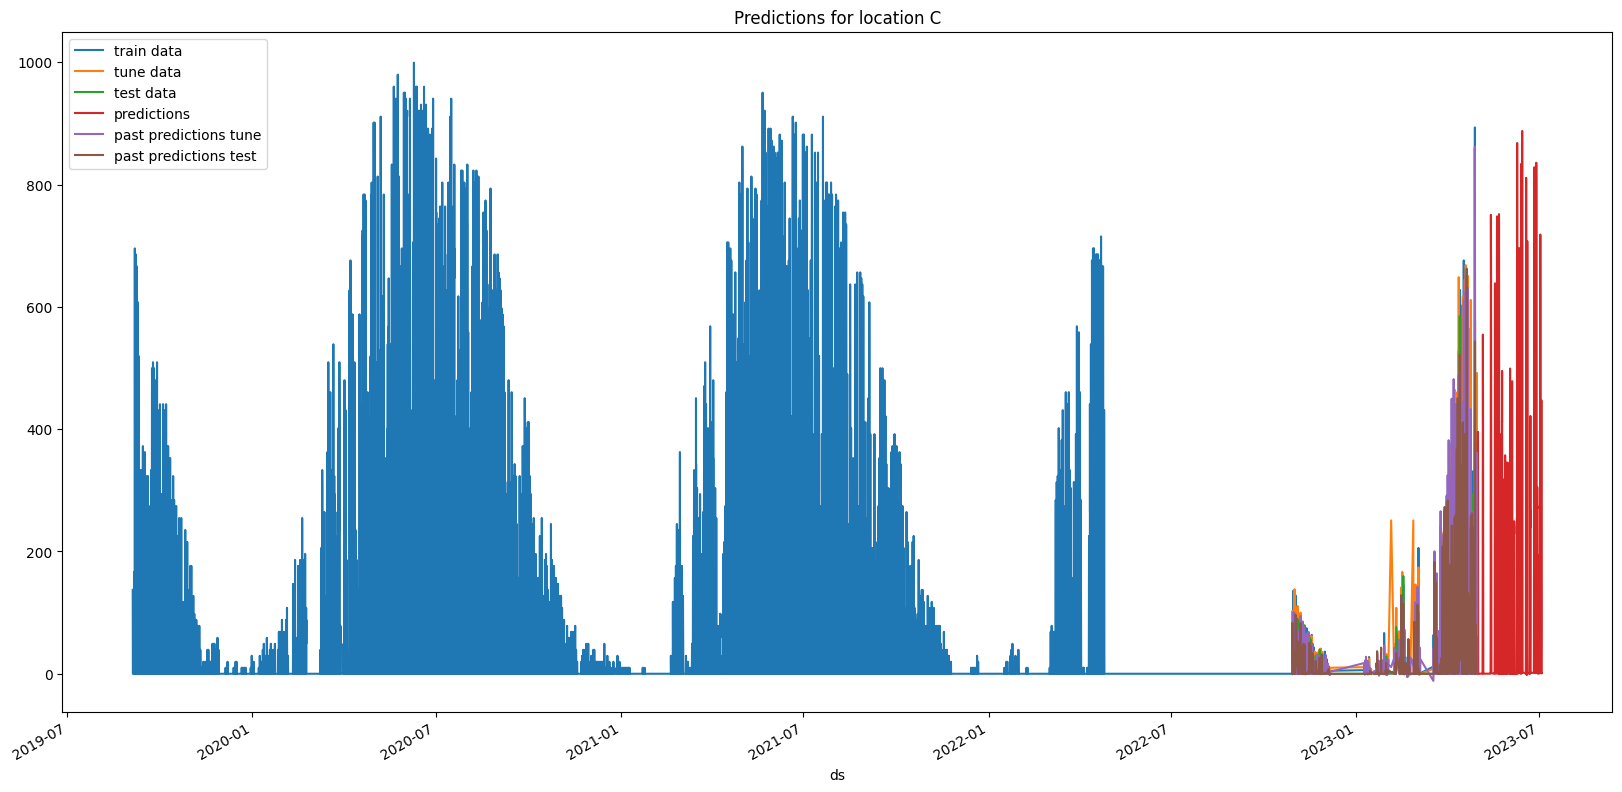

In [ ]:
for loc, idx in location_map.items():
    fig, ax = plt.subplots(figsize=(20, 10))
    # plot train data
    train_data[train_data["location"]==loc].plot(x='ds', y='y', ax=ax, label="train data")
    tuning_data[tuning_data["location"]==loc].plot(x='ds', y='y', ax=ax, label="tune data")
    if use_test_data:
        test_data[test_data["location"]==loc].plot(x='ds', y='y', ax=ax, label="test data")

    # plot predictions
    predictions[idx].plot(x='ds', y='prediction', ax=ax, label="predictions")

    # plot past predictions
    tuning_data[tuning_data["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions tune")
    if use_test_data:
        test_data[test_data["location"]==loc].plot(x='ds', y='prediction', ax=ax, label="past predictions test")


    ax.set_title(f"Predictions for location {loc}")

In [ ]:
temp_predictions = [prediction.copy() for prediction in predictions]
if clip_predictions:
    # clip predictions smaller than 0 to 0
    for pred in temp_predictions:
        # print smallest prediction
        print("Smallest prediction:", pred["prediction"].min())
        pred.loc[pred["prediction"] < 0, "prediction"] = 0
        print("Smallest prediction after clipping:", pred["prediction"].min())


# concatenate predictions
submissions_df = pd.concat(temp_predictions)
submissions_df = submissions_df[["id", "prediction"]]
submissions_df

Smallest prediction: -37.823605
Smallest prediction after clipping: 0.0
Smallest prediction: -2.3058283
Smallest prediction after clipping: 0.0
Smallest prediction: -2.1818242
Smallest prediction after clipping: 0.0


,id,prediction
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,16.584423
4,4,304.872498
...,...,...
715,2155,63.452984
716,2156,34.039520
717,2157,5.225869
718,2158,0.645353


In [ ]:
# Save the submission
print(f"Saving submission to submissions/{new_filename}.csv")
submissions_df.to_csv(os.path.join('submissions', f"{new_filename}.csv"), index=False)

Saving submission to submissions/submission_134.csv


In [ ]:
# feature importance
print("\033[1m" + "Calculating feature importance for location A..." + "\033[0m")
print(predictors[0].feature_importance(feature_stage="original", data=test_data[test_data["location"] == "A"], time_limit=60*10))
print("\033[1m" + "Calculating feature importance for location B..." + "\033[0m")
print(predictors[1].feature_importance(feature_stage="original", data=test_data[test_data["location"] == "B"], time_limit=60*10))
print("\033[1m" + "Calculating feature importance for location C..." + "\033[0m")
print(predictors[2].feature_importance(feature_stage="original", data=test_data[test_data["location"] == "C"], time_limit=60*10))

These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'elevation:m', 'snow_drift:idx', 'location', 'prediction']


Calculating feature importance for location A...


Computing feature importance via permutation shuffling for 44 features using 361 rows with 10 shuffle sets... Time limit: 600s...
	88.72s	= Expected runtime (8.87s per shuffle set)
	53.07s	= Actual runtime (Completed 10 of 10 shuffle sets)
These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'elevation:m', 'location', 'prediction']
Computing feature importance via permutation shuffling for 45 features using 361 rows with 10 shuffle sets... Time limit: 600s...


                                  importance     stddev       p_value   n  \
direct_rad:W                    7.966799e+01   6.196518  8.202915e-12  10   
clear_sky_rad:W                 7.633021e+01  12.170163  4.887011e-09  10   
diffuse_rad:W                   5.799179e+01  10.525372  1.526728e-08  10   
clear_sky_energy_1h:J           3.031519e+01  10.381896  3.459234e-06  10   
sun_elevation:d                 2.939179e+01   7.686730  3.608322e-07  10   
sun_azimuth:d                   2.394524e+01  12.523500  9.566792e-05  10   
diffuse_rad_1h:J                1.427764e+01   4.402150  1.448702e-06  10   
direct_rad_1h:J                 1.398430e+01   5.747896  1.509840e-05  10   
effective_cloud_cover:p         1.397670e+01   4.436740  1.846918e-06  10   
total_cloud_cover:p             1.084766e+01   3.430958  1.791842e-06  10   
snow_water:kgm2                 7.979610e+00   5.356829  5.518101e-04  10   
relative_humidity_1000hPa:p     7.824189e+00   2.658841  3.245806e-06  10   

	307.44s	= Expected runtime (30.74s per shuffle set)
	55.82s	= Actual runtime (Completed 10 of 10 shuffle sets)
These features in provided data are not utilized by the predictor and will be ignored: ['ds', 'elevation:m', 'snow_drift:idx', 'location', 'prediction']
Computing feature importance via permutation shuffling for 44 features using 360 rows with 10 shuffle sets... Time limit: 600s...


                                  importance    stddev       p_value   n  \
clear_sky_rad:W                 3.089353e+01  2.862590  3.928157e-11  10   
direct_rad:W                    1.758631e+01  1.326535  6.232521e-12  10   
diffuse_rad:W                   1.292878e+01  1.449306  2.149220e-10  10   
sun_elevation:d                 8.974525e+00  1.129608  6.024637e-10  10   
sun_azimuth:d                   6.951743e+00  1.180075  8.485674e-09  10   
clear_sky_energy_1h:J           6.795127e+00  1.047551  3.631051e-09  10   
effective_cloud_cover:p         3.173118e+00  0.654582  4.670364e-08  10   
direct_rad_1h:J                 3.120853e+00  0.435006  1.489493e-09  10   
diffuse_rad_1h:J                3.112522e+00  0.729352  1.407778e-07  10   
relative_humidity_1000hPa:p     1.751303e+00  0.483333  5.701084e-07  10   
is_in_shadow:idx                1.597443e+00  0.199220  5.550254e-10  10   
fresh_snow_24h:cm               1.452799e+00  0.497733  3.470695e-06  10   
snow_water:k

	3929.37s	= Expected runtime (392.94s per shuffle set)


KeyboardInterrupt: 

In [ ]:
# save this notebook to submissions folder
import subprocess
import os
subprocess.run(["jupyter", "nbconvert", "--to", "pdf", "--output", os.path.join('notebook_pdfs', f"{new_filename}.pdf"), "short_1.ipynb"])

[NbConvertApp] Converting notebook short_1.ipynb to pdf
[NbConvertApp] Support files will be in notebook_pdfs/submission_134_files/
[NbConvertApp] Making directory ./notebook_pdfs/submission_134_files/notebook_pdfs
[NbConvertApp] Writing 187261 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 560867 bytes to notebook_pdfs/submission_134.pdf


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'pdf', '--output', 'notebook_pdfs/submission_134.pdf', 'short_1.ipynb'], returncode=0)